In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras import datasets, layers, models

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import os
import logging
import warnings

logging.getLogger("tensorflow").setLevel(logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.filterwarnings('ignore')

2025-07-05 21:05:03.155349: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751749503.335566      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751749503.387505      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


implementacao de um pipeline completo para classificação de imagens do dataset CIFAR-10 usando TensorFlow.

as configurações de logging são ajustadas para suprimir warnings e mensagens desnecessárias do TensorFlow.


o dataset CIFAR-10 é carregado usando a função integrada do Keras, que retorna imagens de 32x32 pixels com 3 canais de cor e suas respectivas labels. Os dados são normalizados dividindo por 255.0 para converter valores de pixel do range 0-255 para 0-1, facilitando o treinamento da rede neural.


In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()


x_train = x_train.astype("float32") / 255.0
x_test  = x_test.astype("float32")  / 255.0


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


São definidas constantes globais para controlar o treinamento: 30 épocas, batch size de 64, 10% dos dados para validação, caminhos para salvar modelos, paciência de 10 épocas para early stopping, e métrica de monitoramento baseada na perda de validação.

a função get_callbacks() configura early stopping para evitar overfitting e model checkpoint para salvar o melhor modelo. A função plot_history() cria gráficos das curvas de perda e acurácia durante o treinamento.
A função evaluate_model() avalia o desempenho final no conjunto de teste.

In [3]:
# -------------------------------------------------------------------
# 1) Configurações gerais (hiperparâmetros, caminhos, etc)
# -------------------------------------------------------------------

EPOCHS       = 30
BATCH_SIZE   = 64
VALID_SPLIT  = 0.1
MODEL_PATH   = "best_cifar10_model.h5"
TFLITE_PATH  = "cifar10_simple.tflite"
PATIENCE_ES  = 10
MONITOR_MET  = "val_loss"


# -------------------------------------------------------------------
# 2) Helpers
# -------------------------------------------------------------------
def get_callbacks():
    return [
        EarlyStopping(monitor=MONITOR_MET, patience=PATIENCE_ES, verbose=0, restore_best_weights=True),
        ModelCheckpoint(MODEL_PATH,   monitor=MONITOR_MET, save_best_only=True, verbose=0)
    ]

def plot_history(history):
    plt.figure(figsize=(12,4))

    # Loss
    plt.subplot(1,2,1)
    plt.plot(history.history["loss"], label="train")
    plt.plot(history.history[MONITOR_MET], label="val")
    plt.title("Loss")
    plt.legend()

    # Accuracy
    plt.subplot(1,2,2)
    plt.plot(history.history["accuracy"], label="train")
    plt.plot(history.history["val_accuracy"], label="val")
    plt.title("Accuracy")
    plt.legend()

    plt.show()

def evaluate_model(model, x_test, y_test):
    loss, acc = model.evaluate(x_test, y_test, verbose=0)
    print(f"Acurácia final no test set: {acc:.4f}")
    return loss, acc

def export_tflite(model, filename=TFLITE_PATH):
    print(f"Convertendo modelo para TFLite em `{filename}`...")
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()
    with open(filename, "wb") as f:
        f.write(tflite_model)
    print("✅ Export concluído.")
    #return tflite_model






A função create_balanced_model() cria uma CNN com três blocos convolucionais progressivos (32, 64, 128 filtros), 
cada um com batch normalization, dropout e max pooling.


O modelo é criado usando create_balanced_model(), compilado com otimizador Adam e sparse categorical crossentropy como função de perda. O treinamento usa os callbacks definidos, split de validação automático, e executa por 30 épocas. O histórico é plotado e o modelo é avaliado no conjunto de teste.

In [30]:
#  - large model
# https://www.kaggle.com/code/justinseby1998/cifar-10-validation-accuracy-0-93-and-ce-0-22
# Create a parameter-efficient but effective model

def create_balanced_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(32, 32, 3)),

        tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'), # Conv2D
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Dropout(0.25),

        tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'), # Conv2D
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'), # Conv2D
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'), # Conv2D
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dropout(0.3),

        tf.keras.layers.Dense(10, activation='softmax')
    ])
    return model




In [31]:
# 3. Orquestração do pipeline CIFAR-10 em uma única célula

print("🔨 Criando e compilando modelo para CIFAR-10")
model = create_balanced_model()
#model = create_simple_effective_model()
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)
model.summary()



🔨 Criando e compilando modelo para CIFAR-10


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_38 (Conv2D)                   │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_20               │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_39 (Conv2D)                   │ (None, 32, 32, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_21               │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_26 (Dropout)                 │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_40 (Conv2D)                   │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_22               │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_41 (Conv2D)                   │ (None, 16, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_23               │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_27 (Dropout)                 │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_42 (Conv2D)                   │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_24               │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_6           │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_28 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 141,994 (554.66 KB)

 Trainable params: 141,354 (552.16 KB)

 Non-trainable params: 640 (2.50 KB)


🚂 Iniciando treino por 30 epochs (batch size=64)
Epoch 1/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 18s 13ms/step - accuracy: 0.4239 - loss: 1.5728 - val_accuracy: 0.5904 - val_loss: 1.1183
Epoch 2/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.6211 - loss: 1.0576 - val_accuracy: 0.5886 - val_loss: 1.1600
Epoch 3/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.6822 - loss: 0.8990 - val_accuracy: 0.6610 - val_loss: 0.9538
Epoch 4/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7244 - loss: 0.7987 - val_accuracy: 0.6242 - val_loss: 1.1300
Epoch 5/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7472 - loss: 0.7261 - val_accuracy: 0.7676 - val_loss: 0.6625
Epoch 6/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7670 - loss: 0.6704 - val_accuracy: 0.7260 - val_loss: 0.7969
Epoch 7/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7815 - loss: 0.6257 - val_accuracy: 0.7814 - val_loss: 0.6406
Epoch 8/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step 

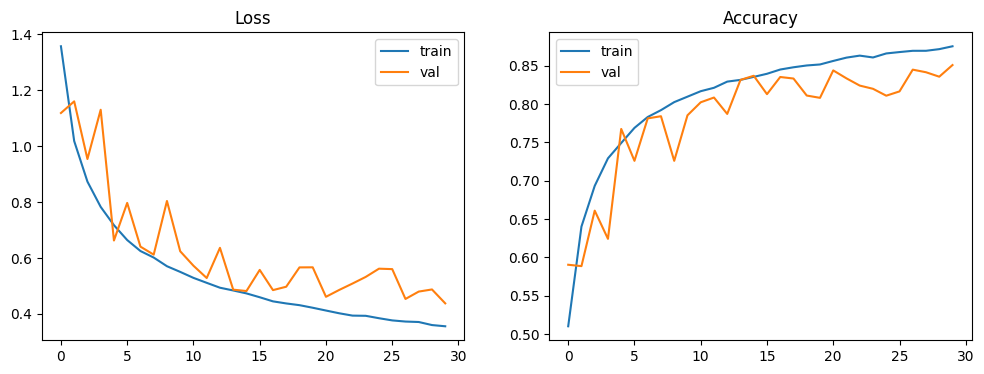


🔍 Avaliando no conjunto de teste
Acurácia final no test set: 0.8417

🛠 Exportando modelo para TFLite
Convertendo modelo para TFLite em `cifar10_simple.tflite`...
Saved artifact at '/tmp/tmpcwzzqry6'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name='keras_tensor_198')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  134009897235088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134009897226832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134005734436368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134005734435600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134005734433296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134005734440400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134005734430800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134005734437520: TensorSpec(shape=(), dtype=tf.resource, n

W0000 00:00:1751751775.030487      35 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1751751775.030515      35 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.


In [32]:
print(f"\n🚂 Iniciando treino por {EPOCHS} epochs (batch size={BATCH_SIZE})")
history = model.fit(
    x_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=VALID_SPLIT,
    callbacks=get_callbacks(),
    verbose=1
)

print("\n📊 Plotando curva de treino")
plot_history(history)

print("\n🔍 Avaliando no conjunto de teste")
evaluate_model(model, x_test, y_test)

print("\n🛠 Exportando modelo para TFLite")
export_tflite(model, TFLITE_PATH)



📊 Plotando curva de treino


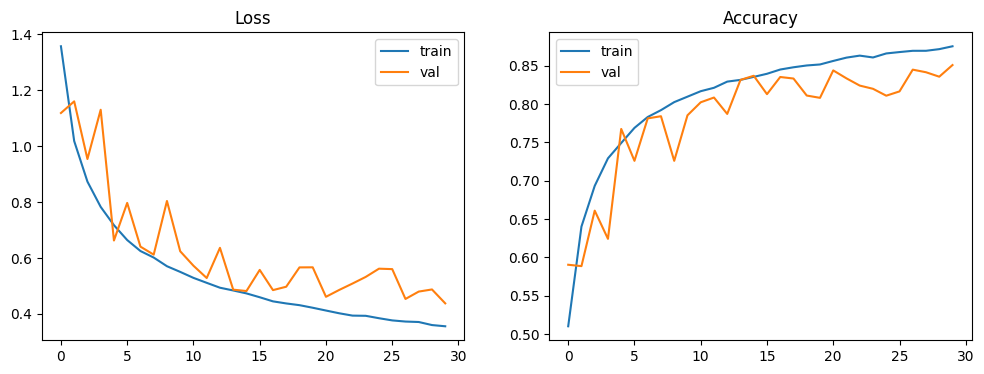


🔍 Avaliando no conjunto de teste
Acurácia final no test set: 0.8417


(0.4615285098552704, 0.84170001745224)

In [33]:
print("\n📊 Plotando curva de treino")
plot_history(history)

print("\n🔍 Avaliando no conjunto de teste")
evaluate_model(model, x_test, y_test)

# Quantizar modelo para int8

In [34]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

CLASS_NAMES = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]
QUANTIZED_MODEL_FILENAME = "cifar10_simple_int8.tflite"

def convert_to_tflite_quantized(keras_model, representative_data, filename):
    print("Converting to TFLite with full integer quantization...")

    def representative_dataset_gen():
        for i in range(len(representative_data)):
            yield [representative_data[i:i+1]]

    converter = tf.lite.TFLiteConverter.from_keras_model(keras_model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    converter.representative_dataset = representative_dataset_gen
    converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
    converter.inference_input_type = tf.int8
    converter.inference_output_type = tf.int8

    tflite_quant_model = converter.convert()

    with open(filename, "wb") as f:
        f.write(tflite_quant_model)

    size_kb = os.path.getsize(filename) / 1024
    print(f"Quantized model saved to {filename} ({size_kb:.1f} KB)")
    return tflite_quant_model

def run_quantized_inference(tflite_model_content, float_image_sample):
    interpreter = tf.lite.Interpreter(model_content=tflite_model_content)
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()[0]
    output_details = interpreter.get_output_details()[0]

    scale, zero_point = input_details["quantization"]
    quantized_input = (float_image_sample / scale + zero_point).astype(input_details["dtype"])

    interpreter.set_tensor(input_details["index"], quantized_input)
    interpreter.invoke()

    quantized_output = interpreter.get_tensor(output_details["index"])
    out_scale, out_zero_point = output_details["quantization"]
    float_output = (quantized_output.astype(np.float32) - out_zero_point) * out_scale

    predicted_label = np.argmax(float_output)
    return predicted_label

def plot_prediction(image, true_name, pred_name):
    plt.figure(figsize=(4, 4))
    plt.imshow(image)
    plt.title(f"True: {true_name}\nPredicted: {pred_name}")
    plt.axis('off')
    plt.show()



Converting to TFLite with full integer quantization...
Saved artifact at '/tmp/tmpv1rbk72d'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name='input_layer_6')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  134005733753872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134005733762512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134005733754448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134005733767888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134005733753104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134005733761744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134005733757904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134005733755216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134005733755024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134008957587280: TensorSpec(s

W0000 00:00:1751751917.416789      35 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1751751917.416826      35 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.


Quantized model saved to cifar10_simple_int8.tflite (155.0 KB)

Verifying inference with the INT8 model...
True Class:      8 (ship)
Predicted Class: 8 (ship)


fully_quantize: 0, inference_type: 6, input_inference_type: INT8, output_inference_type: INT8


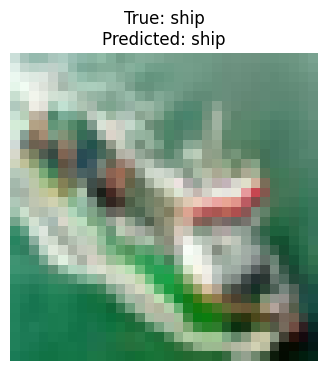

In [35]:
model = tf.keras.models.load_model('/kaggle/working/best_cifar10_model.h5')

(x_train, _), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train = x_train.astype("float32") / 255.0
x_test  = x_test.astype("float32")  / 255.0

representative_data = x_train[:200]
tflite_model_content = convert_to_tflite_quantized(
    keras_model=model,
    representative_data=representative_data,
    filename=QUANTIZED_MODEL_FILENAME
)

print("\nVerifying inference with the INT8 model...")
test_index      = 15
image_sample    = x_test[test_index:test_index+1]
true_label      = int(y_test[test_index][0])
true_name       = CLASS_NAMES[true_label]
predicted_label = run_quantized_inference(tflite_model_content, image_sample)
pred_name       = CLASS_NAMES[predicted_label]

print(f"True Class:      {true_label} ({true_name})")
print(f"Predicted Class: {predicted_label} ({pred_name})")
plot_prediction(image_sample[0], true_name, pred_name)


In [36]:
def evaluate_tflite_model(model_path, x_test, y_test):
    if not os.path.exists(model_path):
        print(f"Erro: Arquivo do modelo não encontrado em '{model_path}'")
        return None

    interpreter = tf.lite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()[0]
    output_details = interpreter.get_output_details()[0]

    input_scale, input_zero_point = input_details["quantization"]
    output_scale, output_zero_point = output_details["quantization"]
    input_dtype = input_details["dtype"]

    correct_predictions = 0
    total_images = len(x_test)

    for i in range(total_images):
        image = x_test[i]
        true_label = y_test[i][0]

        quantized_input = (image / input_scale) + input_zero_point
        quantized_input = np.expand_dims(quantized_input, axis=0).astype(input_dtype)

        interpreter.set_tensor(input_details['index'], quantized_input)
        interpreter.invoke()

        quantized_output = interpreter.get_tensor(output_details['index'])[0]
        dequantized_output = (quantized_output.astype(np.float32) - output_zero_point) * output_scale

        predicted_label = np.argmax(dequantized_output)

        if predicted_label == true_label:
            correct_predictions += 1

    accuracy = correct_predictions / total_images
    return accuracy

TFLITE_MODEL_PATH = 'cifar10_simple_int8.tflite'

(_, _), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_test = x_test.astype("float32") / 255.0

final_accuracy = evaluate_tflite_model(
    model_path=TFLITE_MODEL_PATH,
    x_test=x_test,
    y_test=y_test
)

if final_accuracy is not None:
    print(f"Modelo: {TFLITE_MODEL_PATH}")
    print(f"Imagens de teste: {len(x_test)}")
    print(f"Acurácia final no dataset de teste: {final_accuracy:.4f}")

Modelo: cifar10_simple_int8.tflite
Imagens de teste: 10000
Acurácia final no dataset de teste: 0.8229
